# Style Transfer with Deep Neural Networks

Implement the [Gatys style transfer paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In [1]:
from PIL import Image
import numpy as np

import torch
import torch.optim as optim
import torch.functional as F
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(pretrained=True).features

In [8]:
img = Image.open('greenhouse.png')

In [9]:
img.size

(2494, 2702)

In [25]:
def load_image(img_path, max_size=300, shape=None):
    image = Image.open(img_path)
    
    if max(img.size) > max_size:
        size = max_size
    else:
        size = max(img.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # Discard alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze_(0)
    
    
    return image

In [19]:
def get_features(image, model):

    # To get the layer outputs we need to pass the image forward through the network 
    # until we get to the desired layer and get the output from that layer

    layers = {'0': 'conv1_1', 
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [20]:
def gram_matrix(tensor):
    # Batch, channels, height, width
    _, c, h, w = tensor.size()
    
    # Reshape so we're multiplying the features for each channel
    tensor = tensor.view(c, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    # Normalize the gram matrix
    return gram / (c * h * w)

In [29]:
content = load_image('octavia.jpg')
# Resize style to match content, makes code easier
style = load_image('greenhouse.png', shape=content.shape[-2:])

# Calculate content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [92]:
style_weights = {'conv1_1': 0.5,
                 'conv2_1': 0.75,
                 'conv3_1': 1,
                 'conv4_1': 1.5,
                 'conv5_1': 2}

target = torch.rand_like(content).requires_grad_(True)

tensor(1.0277e+13)


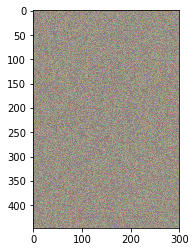

tensor(9.9403e+12)


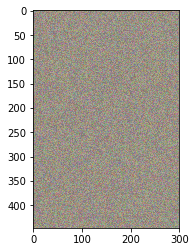

KeyboardInterrupt: 

In [98]:
steps = 10
optimizer = optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
loss_ratio = 1e-3
show_every = 1

for ii in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = 0.5*(content_features['conv4_1'].detach() - target_features['conv4_1']).sum()**2
    
    target_grams = {layer: gram_matrix(target_features[layer]) for layer in target_features}
    layer_losses = {each: (style_features[each].detach() - target_features[each]).sum()**2 for each in target_features}
    style_loss = sum(style_weights[each]*layer_losses[each] for each in layer_losses)
    
    total_loss = loss_ratio * content_loss + style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print(total_loss.item())
        imshow(target)
        plt.show()

In [47]:
%matplotlib inline

import matplotlib.pyplot as plt

In [87]:
def imshow(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    plt.imshow(image)

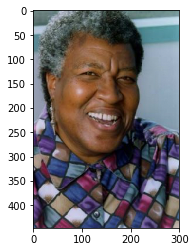

In [88]:
imshow(target)